## 1. Imports

In [ ]:
# !pip install transformers timm torchvision torch indic-nlp-library langdetect

In [1]:
import os, json, torch, random, numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModel
from torch import nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


## 2. Load and Split Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_path = "/content/drive/MyDrive/Dataset/final_data.json"
with open(data_path, "r", encoding="utf-8") as f:
    data = json.load(f)

random.shuffle(data)
df = pd.DataFrame(data)

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42, stratify=df['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")


Train: 1491, Val: 320, Test: 320


## 3. Dataset Class

In [4]:
class MemeDataset(Dataset):
    def __init__(self, dataframe, processor, tokenizer, max_length=128):
        self.data = dataframe
        self.processor = processor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image = Image.open(item['img']).convert("RGB")
        image_input = self.processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        text_input = self.tokenizer(item['text'], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            'image': image_input,
            'input_ids': text_input['input_ids'].squeeze(0),
            'attention_mask': text_input['attention_mask'].squeeze(0),
            'label': torch.tensor(item['label'], dtype=torch.long)
        }

clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
text_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

train_loader = DataLoader(MemeDataset(train_df, clip_processor, text_tokenizer), batch_size=16, shuffle=True)
val_loader = DataLoader(MemeDataset(val_df, clip_processor, text_tokenizer), batch_size=16)
test_loader = DataLoader(MemeDataset(test_df, clip_processor, text_tokenizer), batch_size=16)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

## 4. Multimodal Model

In [5]:
class MultimodalClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.clip = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
        self.text_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.clip.config.projection_dim + self.text_model.config.hidden_size, 2)

    def forward(self, image, input_ids, attention_mask):
        with torch.no_grad():
            img_features = self.clip.get_image_features(image)
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.last_hidden_state[:, 0, :]
        combined = torch.cat((img_features, text_features), dim=1)
        combined = self.dropout(combined)
        return self.fc(combined)

model = MultimodalClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

## 5. Training with Validation

In [6]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_val_acc = 0

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in tqdm(train_loader):
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_acc = total_correct / len(train_loader.dataset)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for batch in val_loader:
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(image, input_ids, attention_mask)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(dim=1) == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_acc = val_correct / len(val_loader.dataset)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")

100%|██████████| 94/94 [21:53<00:00, 13.97s/it]


Epoch 1 | Train Loss: 0.6785, Train Acc: 0.5647, Val Loss: 0.5742, Val Acc: 0.6937


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


Epoch 2 | Train Loss: 0.5202, Train Acc: 0.7371, Val Loss: 0.5227, Val Acc: 0.7063


100%|██████████| 94/94 [01:11<00:00,  1.32it/s]


Epoch 3 | Train Loss: 0.3545, Train Acc: 0.8457, Val Loss: 0.5433, Val Acc: 0.7000


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


Epoch 4 | Train Loss: 0.2000, Train Acc: 0.9168, Val Loss: 0.5871, Val Acc: 0.7750


100%|██████████| 94/94 [01:11<00:00,  1.31it/s]


Epoch 5 | Train Loss: 0.0988, Train Acc: 0.9584, Val Loss: 0.6963, Val Acc: 0.8313


100%|██████████| 94/94 [01:10<00:00,  1.33it/s]


Epoch 6 | Train Loss: 0.0798, Train Acc: 0.9618, Val Loss: 0.6760, Val Acc: 0.8156


100%|██████████| 94/94 [01:25<00:00,  1.10it/s]


Epoch 7 | Train Loss: 0.0659, Train Acc: 0.9691, Val Loss: 0.6851, Val Acc: 0.8375


100%|██████████| 94/94 [01:29<00:00,  1.06it/s]


Epoch 8 | Train Loss: 0.0388, Train Acc: 0.9772, Val Loss: 0.8666, Val Acc: 0.8250


100%|██████████| 94/94 [01:26<00:00,  1.09it/s]


Epoch 9 | Train Loss: 0.0578, Train Acc: 0.9752, Val Loss: 0.7433, Val Acc: 0.8344


100%|██████████| 94/94 [01:16<00:00,  1.23it/s]


Epoch 10 | Train Loss: 0.0444, Train Acc: 0.9738, Val Loss: 0.8278, Val Acc: 0.8500


## 6. Evaluation on Test Set

In [7]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(image, input_ids, attention_mask)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print("Test Accuracy:", accuracy_score(all_labels, all_preds))
print("Classification Report:\n", classification_report(all_labels, all_preds))


Test Accuracy: 0.809375
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81       160
           1       0.81      0.81      0.81       160

    accuracy                           0.81       320
   macro avg       0.81      0.81      0.81       320
weighted avg       0.81      0.81      0.81       320



## 7. Plots

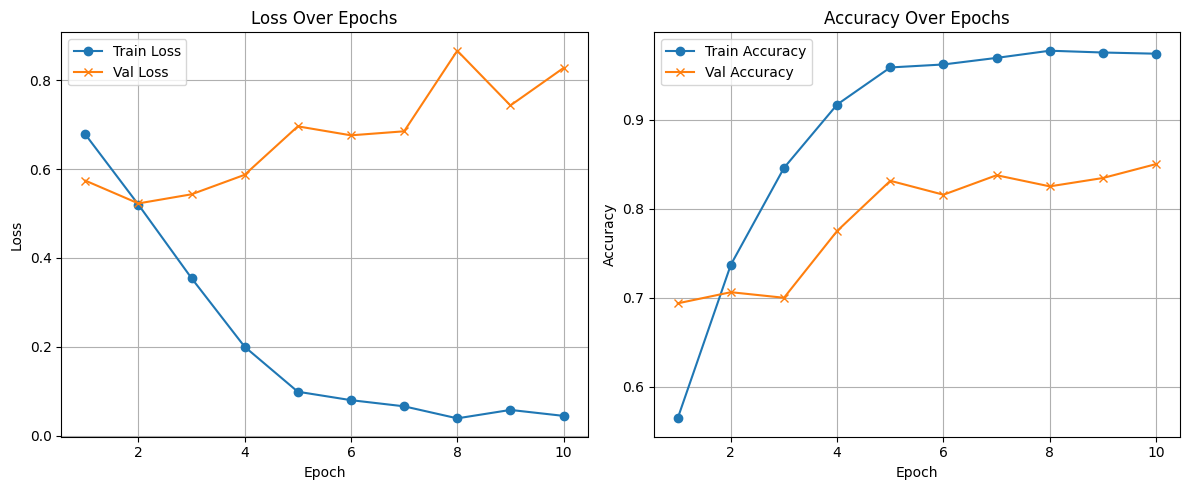

In [8]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss", marker='o')
plt.plot(epochs_range, val_losses, label="Val Loss", marker='x')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(epochs_range, val_accuracies, label="Val Accuracy", marker='x')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 8. Confusion Matrix

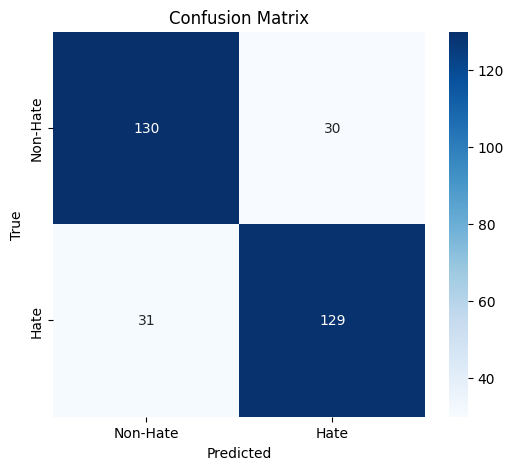

In [9]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Hate', 'Hate'], yticklabels=['Non-Hate', 'Hate'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# benchmark

In [10]:
from transformers import AutoModel, AutoTokenizer, ViTModel, ViTFeatureExtractor
import torch.nn.functional as F

In [11]:
from sklearn.model_selection import train_test_split

# Initial split
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['label'], random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=0.15, stratify=train_val_df['label'], random_state=42)

train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [12]:
class BenchmarkMemeDataset(Dataset):
    def __init__(self, dataframe, extractor, tokenizer, max_length=128):
        self.data = dataframe
        self.extractor = extractor
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        image = Image.open(item['img']).convert("RGB")
        img_tensor = self.extractor(images=image, return_tensors="pt")['pixel_values'].squeeze(0)
        text_tensor = self.tokenizer(item['text'], padding="max_length", truncation=True, max_length=self.max_length, return_tensors="pt")
        return {
            'image': img_tensor,
            'input_ids': text_tensor['input_ids'].squeeze(0),
            'attention_mask': text_tensor['attention_mask'].squeeze(0),
            'label': torch.tensor(item['label'], dtype=torch.long)
        }


In [13]:
vit_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224-in21k")
text_tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [14]:
train_ds = BenchmarkMemeDataset(train_df, vit_extractor, text_tokenizer)
val_ds = BenchmarkMemeDataset(val_df, vit_extractor, text_tokenizer)
test_ds = BenchmarkMemeDataset(test_df, vit_extractor, text_tokenizer)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16)
test_loader = DataLoader(test_ds, batch_size=16)


In [15]:
class BenchmarkModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.text_model = AutoModel.from_pretrained("bert-base-multilingual-cased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.vit.config.hidden_size + self.text_model.config.hidden_size, 2)

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.vit(pixel_values=image).last_hidden_state[:, 0, :]  # [CLS]
        txt_feat = self.text_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]  # [CLS]
        fused = torch.cat((img_feat, txt_feat), dim=1)
        fused = self.dropout(fused)
        return self.fc(fused)


In [16]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, correct = 0, 0
    for batch in tqdm(loader):
        optimizer.zero_grad()
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for batch in loader:
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(image, input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()

    return total_loss / len(loader), correct / len(loader.dataset)


In [17]:
bmodel = BenchmarkModel().to(device)
optimizer = torch.optim.AdamW(bmodel.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
epochs = 6

for epoch in range(epochs):
    t_loss, t_acc = train_one_epoch(bmodel, train_loader, optimizer, criterion)
    v_loss, v_acc = evaluate(bmodel, val_loader, criterion)

    train_losses.append(t_loss)
    val_losses.append(v_loss)
    train_accuracies.append(t_acc)
    val_accuracies.append(v_acc)

    print(f"Epoch {epoch+1}/{epochs}: Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

100%|██████████| 97/97 [01:52<00:00,  1.16s/it]


Epoch 1/6: Train Loss: 0.5079, Train Acc: 0.7739, Val Loss: 0.3544, Val Acc: 0.8824


100%|██████████| 97/97 [01:53<00:00,  1.17s/it]


Epoch 2/6: Train Loss: 0.2362, Train Acc: 0.9350, Val Loss: 0.2904, Val Acc: 0.8860


100%|██████████| 97/97 [01:53<00:00,  1.17s/it]


Epoch 3/6: Train Loss: 0.1134, Train Acc: 0.9714, Val Loss: 0.3021, Val Acc: 0.9007


100%|██████████| 97/97 [01:53<00:00,  1.17s/it]


Epoch 4/6: Train Loss: 0.0610, Train Acc: 0.9857, Val Loss: 0.3660, Val Acc: 0.8787


100%|██████████| 97/97 [01:52<00:00,  1.15s/it]


Epoch 5/6: Train Loss: 0.0307, Train Acc: 0.9942, Val Loss: 0.3948, Val Acc: 0.8860


100%|██████████| 97/97 [01:51<00:00,  1.15s/it]


Epoch 6/6: Train Loss: 0.0204, Train Acc: 0.9961, Val Loss: 0.3950, Val Acc: 0.9007


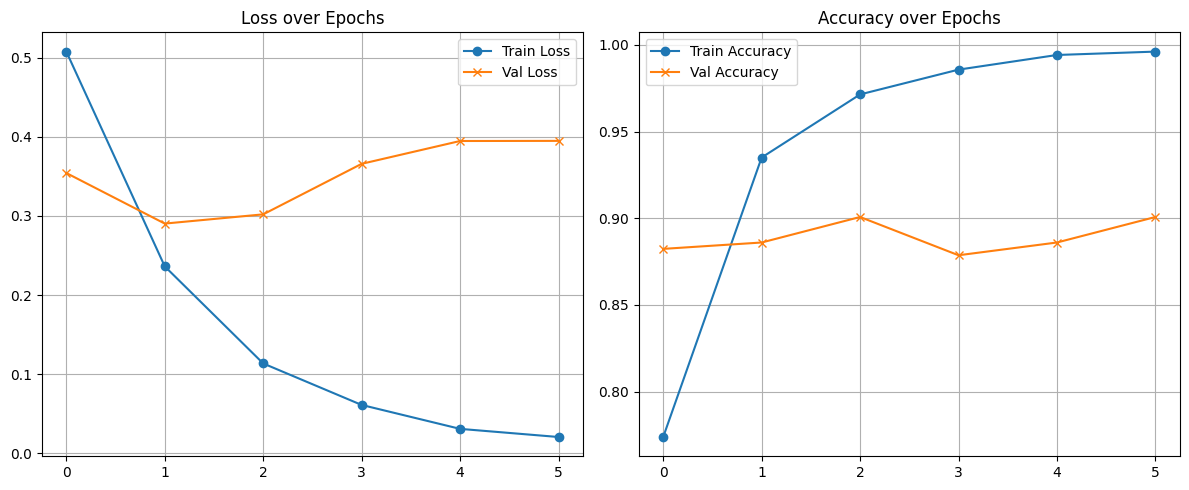

In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Val Loss', marker='x')
plt.title("Loss over Epochs")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', marker='o')
plt.plot(val_accuracies, label='Val Accuracy', marker='x')
plt.title("Accuracy over Epochs")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


In [19]:
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.2851, Test Accuracy: 0.9219


# Models Analysis

In [23]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss, total_correct = 0, 0

    for batch in loader:
        image = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        outputs = model(image, input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

def evaluate(model, loader, criterion):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.no_grad():
        for batch in loader:
            image = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(image, input_ids, attention_mask)
            total_loss += criterion(outputs, labels).item()
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = total_correct / len(loader.dataset)
    return avg_loss, accuracy

In [24]:
bmodel = BenchmarkModel().to(device)
b_optimizer = torch.optim.AdamW(bmodel.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

b_train_losses, b_val_losses = [], []
b_train_accs, b_val_accs = [], []

epochs_b = 6

for epoch in range(epochs_b):
    t_loss, t_acc = train_one_epoch(bmodel, train_loader, b_optimizer, criterion)
    v_loss, v_acc = evaluate(bmodel, val_loader, criterion)

    b_train_losses.append(t_loss)
    b_val_losses.append(v_loss)
    b_train_accs.append(t_acc)
    b_val_accs.append(v_acc)

    print(f"[BMODEL] Epoch {epoch+1}: Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")

[BMODEL] Epoch 1: Train Loss: 0.4948, Train Acc: 0.7667, Val Loss: 0.3606, Val Acc: 0.8493
[BMODEL] Epoch 2: Train Loss: 0.2283, Train Acc: 0.9298, Val Loss: 0.3197, Val Acc: 0.8860
[BMODEL] Epoch 3: Train Loss: 0.0913, Train Acc: 0.9740, Val Loss: 0.3885, Val Acc: 0.8676
[BMODEL] Epoch 4: Train Loss: 0.0487, Train Acc: 0.9903, Val Loss: 0.4403, Val Acc: 0.8640
[BMODEL] Epoch 5: Train Loss: 0.0273, Train Acc: 0.9942, Val Loss: 0.4899, Val Acc: 0.8750
[BMODEL] Epoch 6: Train Loss: 0.0161, Train Acc: 0.9968, Val Loss: 0.5270, Val Acc: 0.8860


In [25]:
model = model.to(device)  # your CLIP model
c_optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

c_train_losses, c_val_losses = [], []
c_train_accs, c_val_accs = [], []

epochs_c = 10

for epoch in range(epochs_c):
    t_loss, t_acc = train_one_epoch(model, train_loader, c_optimizer, criterion)
    v_loss, v_acc = evaluate(model, val_loader, criterion)

    c_train_losses.append(t_loss)
    c_val_losses.append(v_loss)
    c_train_accs.append(t_acc)
    c_val_accs.append(v_acc)

    print(f"[CLIP-LORA] Epoch {epoch+1}: Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")

[CLIP-LORA] Epoch 1: Train Loss: 0.0234, Train Acc: 0.9929, Val Loss: 0.5843, Val Acc: 0.8676
[CLIP-LORA] Epoch 2: Train Loss: 0.0168, Train Acc: 0.9974, Val Loss: 0.4195, Val Acc: 0.8897
[CLIP-LORA] Epoch 3: Train Loss: 0.0286, Train Acc: 0.9909, Val Loss: 0.5836, Val Acc: 0.8603
[CLIP-LORA] Epoch 4: Train Loss: 0.0355, Train Acc: 0.9916, Val Loss: 0.4136, Val Acc: 0.8897
[CLIP-LORA] Epoch 5: Train Loss: 0.0387, Train Acc: 0.9870, Val Loss: 0.4881, Val Acc: 0.8897
[CLIP-LORA] Epoch 6: Train Loss: 0.0137, Train Acc: 0.9961, Val Loss: 0.4769, Val Acc: 0.8934
[CLIP-LORA] Epoch 7: Train Loss: 0.0090, Train Acc: 0.9974, Val Loss: 0.5192, Val Acc: 0.8860
[CLIP-LORA] Epoch 8: Train Loss: 0.0079, Train Acc: 0.9968, Val Loss: 0.6988, Val Acc: 0.8676
[CLIP-LORA] Epoch 9: Train Loss: 0.0078, Train Acc: 0.9968, Val Loss: 0.5456, Val Acc: 0.8860
[CLIP-LORA] Epoch 10: Train Loss: 0.0065, Train Acc: 0.9974, Val Loss: 0.5817, Val Acc: 0.8934


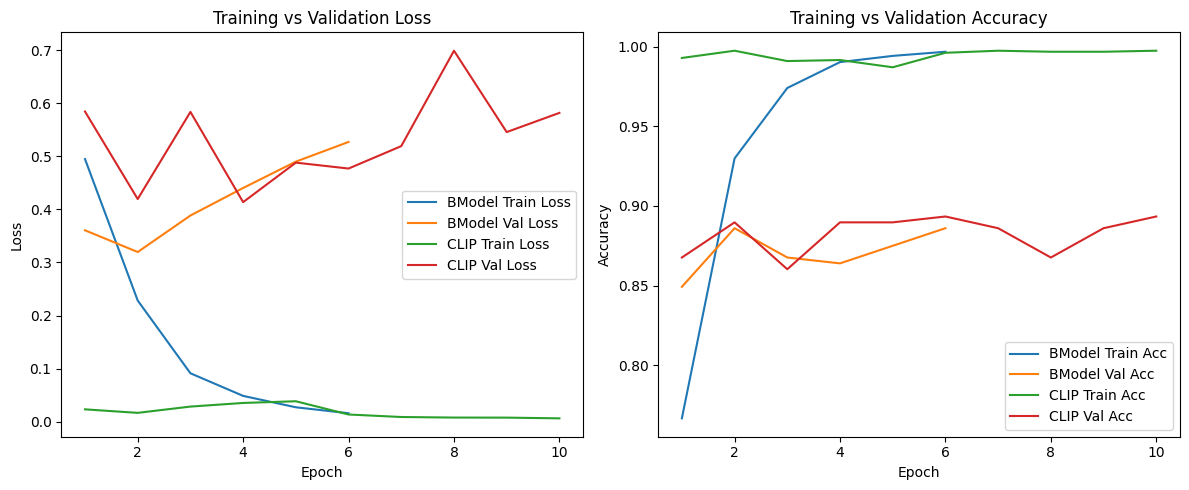

In [26]:
import matplotlib.pyplot as plt

epochs_range_b = range(1, epochs_b + 1)
epochs_range_c = range(1, epochs_c + 1)

# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range_b, b_train_losses, label='BModel Train Loss')
plt.plot(epochs_range_b, b_val_losses, label='BModel Val Loss')
plt.plot(epochs_range_c, c_train_losses, label='CLIP Train Loss')
plt.plot(epochs_range_c, c_val_losses, label='CLIP Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range_b, b_train_accs, label='BModel Train Acc')
plt.plot(epochs_range_b, b_val_accs, label='BModel Val Acc')
plt.plot(epochs_range_c, c_train_accs, label='CLIP Train Acc')
plt.plot(epochs_range_c, c_val_accs, label='CLIP Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [27]:
import pandas as pd

summary = {
    "Model": ["BenchmarkModel", "CLIP-Lora"],
    "Epochs": [epochs_b, epochs_c],
    "Final Train Accuracy": [b_train_accs[-1], c_train_accs[-1]],
    "Final Val Accuracy": [b_val_accs[-1], c_val_accs[-1]],
    "Final Val Loss": [b_val_losses[-1], c_val_losses[-1]],
}
summary_df = pd.DataFrame(summary)
print(summary_df)

            Model  Epochs  Final Train Accuracy  Final Val Accuracy  \
0  BenchmarkModel       6              0.996751            0.886029   
1       CLIP-Lora      10              0.997401            0.893382   

   Final Val Loss  
0        0.526972  
1        0.581745  


## Test with Sample input

In [28]:
from PIL import Image

def predict_sample(model, sample, processor, tokenizer, device="cuda"):
    model.eval()

    image = Image.open(sample['img']).convert("RGB")
    image_input = processor(images=image, return_tensors="pt")['pixel_values'].squeeze(0).to(device)

    text_input = tokenizer(sample['text'], padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(image_input.unsqueeze(0), text_input['input_ids'], text_input['attention_mask'])
        prediction = outputs.argmax(dim=1).item()

    return prediction


In [30]:
correct_clip = 0
correct_benchmark = 0

for _, row in test_df.iterrows():
    true_label = row['label']
    pred_clip = predict_sample(model, row, clip_processor, text_tokenizer)
    pred_benchmark = predict_sample(bmodel, row, clip_processor, text_tokenizer)

    if pred_clip == true_label:
        correct_clip += 1
    if pred_benchmark == true_label:
        correct_benchmark += 1

total = len(test_df)
print(f"\n CLIP-Lora Test Accuracy: {correct_clip / total:.4f}")
print(f" BenchmarkModel Test Accuracy: {correct_benchmark / total:.4f}")



 CLIP-Lora Test Accuracy: 0.9094
 BenchmarkModel Test Accuracy: 0.8844


Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: ur friends gf shows every1 how much she loves her bf after fucking with u full day while her bf is at office
True Label: 1 | Predicted: 1

BenchmarkModel Prediction
Text: ur friends gf shows every1 how much she loves her bf after fucking with u full day while her bf is at office
True Label: 1 | Predicted: 1


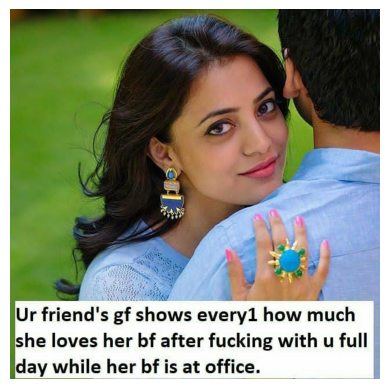

In [40]:
import matplotlib.pyplot as plt
from PIL import Image

sample = test_df.iloc[10]  # Can loop over a few for more tests
print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")
# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: abhaaa em minguthunay ra night nunchi asalu opika ledhu kaani lechina ne modda chusthe asalu agatledhu twaraga rara chekipedathaa
True Label: 1 | Predicted: 1

BenchmarkModel Prediction
Text: abhaaa em minguthunay ra night nunchi asalu opika ledhu kaani lechina ne modda chusthe asalu agatledhu twaraga rara chekipedathaa
True Label: 1 | Predicted: 1


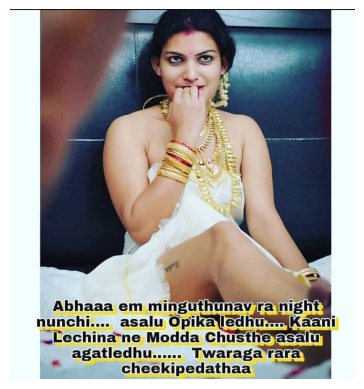

In [41]:
sample = test_df.iloc[116]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: someone nee pellepudu what i want to say but what i say nee saveppudu cheskunta le melliga
True Label: 0 | Predicted: 0

BenchmarkModel Prediction
Text: someone nee pellepudu what i want to say but what i say nee saveppudu cheskunta le melliga
True Label: 0 | Predicted: 0


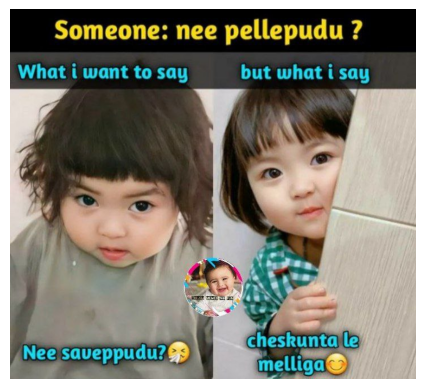

In [42]:
sample = test_df.iloc[120]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()

Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: మనకోసం వారి పెళ్లి సందడి cale ale se ale sek మనకోసం వారి పెళ్లి సు ఆరేళ్లగా పెళ్లి కోసం పరితపిస్తూ us ఇండియా లో అబ్బాయిలు దొరక్క ముప్మై లోకి అడుగుపెట్టి చైనా మంగోలియా చివరికి పాకిస్థాన్ లో ఐనా నన్ను పెళ్లి చేస్కునే వాడు లేదా అని దిగులు చెందుతున్న సమయం లో నేనున్నానే నాయనమ్మ అంటూ ముందుకొచ్చిన atlanta అమాయకుడు నలెదు పై జాలి చూపిస్తూ మా ప్రాణమిత్రురాలు arkansas ఆణిముత్యం వివాహ శుభాకాంక్షలు తెలియచేస్తున్న మనకోసం స్నేహ సమూహం la id అప్పుడప్పుడూ మందు తాగడం తాగినప్పుడు మాత్రమే సిగరెట్టు బీడీ కాల్చడం ఇవేవీ కనప్పుడు గంజాయి కొట్టడం తప్ప వేరే వ్యసనాలు ఏమి లేని ఆదర్శ మహిళ వంట వారువాయి వంటల్లో భీముడికి సాటి తినడం లో బకాసురుడి పోటీ వేడి నీళ్లు కాయడంలో దిట్ట కుట్లు అల్లికలు రాకపోయినా joint లు చుట్టడంలో మహారాణి కొన్ని రోజులుగా పెరుగు తోడు వేయడంలో శిక్షణ తీస్కుంటుంది pri michigan dlace virginia michigan driver license america nri la frustration ఉడికించిన గుడ్డు పొట్టు తీయడంలో తనకి లేరు పోటి ఫ్రీడ్జ్ లో చల్లటి ఐస్ క్యూబ్స్ చేయడంలో తనే బెస్ట్ పుచ్

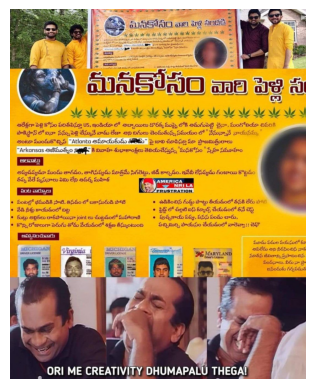

In [44]:
sample = test_df.iloc[292]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: school ki vellakunda teacher ki baita dorkinapudu me vammo chusesindha
True Label: 0 | Predicted: 0

BenchmarkModel Prediction
Text: school ki vellakunda teacher ki baita dorkinapudu me vammo chusesindha
True Label: 0 | Predicted: 0


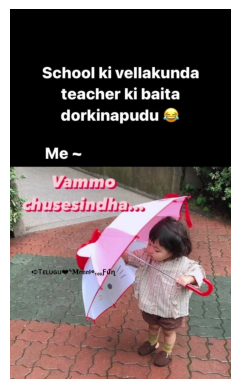

In [48]:
sample = test_df.iloc[32]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: telugu fantasy world naku puvvu nakinchu idhantha nakenduku kovadam chala istam chepthunavu vey voga video nenu nitho veskune appudu nenu puvvu nakanu istam undadu ante ela telugu fantasy wo vyoka orini nen enti vidtho ila open aipoya video vic
True Label: 1 | Predicted: 1

BenchmarkModel Prediction
Text: telugu fantasy world naku puvvu nakinchu idhantha nakenduku kovadam chala istam chepthunavu vey voga video nenu nitho veskune appudu nenu puvvu nakanu istam undadu ante ela telugu fantasy wo vyoka orini nen enti vidtho ila open aipoya video vic
True Label: 1 | Predicted: 1


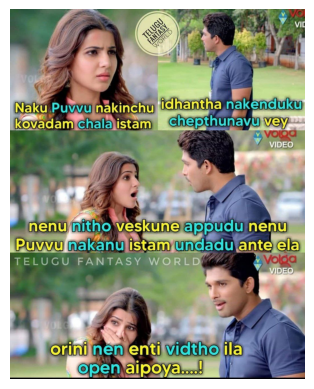

In [52]:
sample = test_df.iloc[19]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: naughty reaction from our bestie when u told her that u did without helmet and released inside her hole
True Label: 1 | Predicted: 1

BenchmarkModel Prediction
Text: naughty reaction from our bestie when u told her that u did without helmet and released inside her hole
True Label: 1 | Predicted: 1


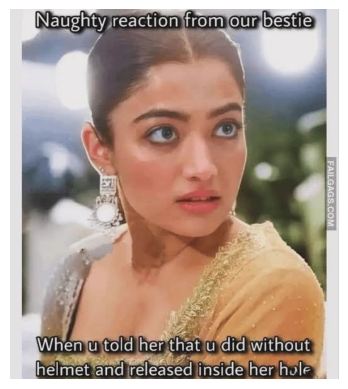

In [54]:
sample = test_df.iloc[109]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


Note : 1 - HATE and 0- Not_Hate

CLIP-Lora Prediction
Text: cmc official భార్య చనిపోయిన 6 నెలలకి భర్త నవ్వుతున్నట్లు కనిపిస్తే common man counters cmc జనాలు పాపం బాధని దిగమింది నవ్వుతున్నటు నటిస్తున్నాడు అదే జనాలు భర్త చనిపోయిన 2yrs తర్వాత భార్య నవ్వుతున్నట్లు కనిపిస్తే భర్త పోయి 2yts కాలేదు అప్పుడే ఎంత సంతోషంగా ఉంది ఈ వగలాడి ఇదే చంపేసి ఉంటుంది మొగుడ్ని
True Label: 0 | Predicted: 0

BenchmarkModel Prediction
Text: cmc official భార్య చనిపోయిన 6 నెలలకి భర్త నవ్వుతున్నట్లు కనిపిస్తే common man counters cmc జనాలు పాపం బాధని దిగమింది నవ్వుతున్నటు నటిస్తున్నాడు అదే జనాలు భర్త చనిపోయిన 2yrs తర్వాత భార్య నవ్వుతున్నట్లు కనిపిస్తే భర్త పోయి 2yts కాలేదు అప్పుడే ఎంత సంతోషంగా ఉంది ఈ వగలాడి ఇదే చంపేసి ఉంటుంది మొగుడ్ని
True Label: 0 | Predicted: 0


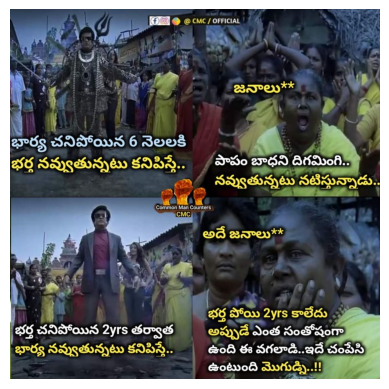

In [55]:
sample = test_df.iloc[159]  # Can loop over a few for more tests

print("Note : 1 - HATE and 0- Not_Hate\n")
# Predict using CLIP-Lora
pred_clip = predict_sample(model, sample, clip_processor, text_tokenizer)
print("CLIP-Lora Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_clip}")

# Predict using BenchmarkModel
pred_benchmark = predict_sample(bmodel, sample, clip_processor, text_tokenizer)
print("\nBenchmarkModel Prediction")
print(f"Text: {sample['text']}")
print(f"True Label: {sample['label']} | Predicted: {pred_benchmark}")

# Get the image and show it
image = Image.open(sample['img']).convert("RGB")
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()
